# Predictive Modelling - Transfer Learning

Author: Frauke Albrecht
<div>
<img src="Images/vgg16_architecture.png" width="600"/>
</div>  

Another possibility to tackle the classification problem is by using a pre-trained model and add a prediction layer. We will use the VGG16 model, which is a convolutional neural network model proposed by K. Simonyan and A. Zisserman. It was trained on the ImageNet dataset, which is a dataset of over 15 million labeled high-resolution images belonging to about 22,000 categories.  In a first step we will keep the model as it is and only add an output layer and in a second step we will defreeze some of the layers and train them on our data. 

## Setup

In [148]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from keras.metrics import sparse_categorical_crossentropy
import os

## Read the Data

In [57]:
# path containing the training data
train_dir = 'dataset2-master/dataset2-master/images/TRAIN/train_img/'
# path containing the test data
val_dir = 'dataset2-master/dataset2-master/images/TEST/test_img/'

In [58]:
# directories with training pictures of each type
train_eos_dir = os.path.join(train_dir, 'eosinophil')  
train_neu_dir = os.path.join(train_dir, 'neutrophil') 
train_lym_dir = os.path.join(train_dir, 'lymphocyte')  
train_mon_dir = os.path.join(train_dir, 'monocyte') 
# directories with test pictures of each type
val_eos_dir = os.path.join(val_dir, 'eosinophil')  
val_neu_dir = os.path.join(val_dir, 'neutrophil')  
val_lym_dir = os.path.join(val_dir, 'lymphocyte')
val_mon_dir = os.path.join(val_dir, 'monocyte')

In [59]:
# How many pictures do we have?
num_eos_tr = len(os.listdir(train_eos_dir))
num_neu_tr = len(os.listdir(train_neu_dir))
num_lym_tr = len(os.listdir(train_lym_dir))
num_mon_tr = len(os.listdir(train_mon_dir))

num_eos_val = len(os.listdir(val_eos_dir))
num_neu_val = len(os.listdir(val_neu_dir))
num_lym_val = len(os.listdir(val_lym_dir))
num_mon_val = len(os.listdir(val_mon_dir))

total_train = num_eos_tr + num_neu_tr + num_lym_tr + num_mon_tr
total_val  = num_eos_val + num_neu_val + num_lym_val + num_mon_val

In [87]:
batch_size = 128
epochs     = 10
IMG_HEIGHT = 120#240#60
IMG_WIDTH  = 160#320#80

In [98]:
# prepare the data
# further data augmentaion
train_image_generator= ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest', validation_split=0.25)
validation_image_generator  = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [99]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 9957 images belonging to 4 classes.


In [100]:
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='sparse')

Found 2487 images belonging to 4 classes.


## Build the model

Use the VGG16 model as the base model than add a Global Average Pooling layer together with Batch Normalization and Dropout. The Global Average Pooling layer is used to reduce the spatial dimensionality of a given tensor without varying the depth by taking the average of all spatial components. 

In [150]:
base_model = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 40, 128)       0     

In [151]:
# Add a global spatial average pooling layer
model = Sequential([base_model,
                    BatchNormalization(),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Dropout(0.4),
                    Dense(4, activation='softmax')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 5, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 5, 512)         2048      
_________________________________________________________________
dropout (Dropout)            (None, 3, 5, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,718,788
Trainable params: 14,717,764
Non-trainable params: 1,024
________________________________________

### Freeze the Layers of VGG16

In [152]:
# first: train only the top layers i.e. freeze all convolutional vgg16 layers
for layer in base_model.layers:
    layer.trainable = False

In [153]:
# compile the model
model.compile(optimizer='adam',            
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training and Evaluation

Due to computational limitations we will only train the model for 10 epochs.

In [106]:
# Train the model
history = model.fit_generator(train_data_gen,
                      steps_per_epoch=total_train // batch_size,
                      validation_data=validation_data_gen,
                      validation_steps=total_val // batch_size,
                      epochs = epochs,
                      verbose = 1)

Epoch 1/10
77/77 [==============================] - 1644s 21s/step - loss: 1.3788 - accuracy: 0.3438 - val_loss: 1.4396 - val_accuracy: 0.3409
Epoch 2/10
77/77 [==============================] - 2339s 30s/step - loss: 1.1949 - accuracy: 0.4675 - val_loss: 1.2951 - val_accuracy: 0.4053
Epoch 3/10
77/77 [==============================] - 2291s 30s/step - loss: 1.1351 - accuracy: 0.5089 - val_loss: 1.2322 - val_accuracy: 0.4616
Epoch 4/10
77/77 [==============================] - 1924s 25s/step - loss: 1.0939 - accuracy: 0.5325 - val_loss: 1.1959 - val_accuracy: 0.4782
Epoch 5/10
77/77 [==============================] - 2245s 29s/step - loss: 1.0703 - accuracy: 0.5425 - val_loss: 1.1693 - val_accuracy: 0.4570
Epoch 6/10
77/77 [==============================] - 1768s 23s/step - loss: 1.0450 - accuracy: 0.5587 - val_loss: 1.0641 - val_accuracy: 0.4722
Epoch 7/10
77/77 [==============================] - 1947s 25s/step - loss: 1.0386 - accuracy: 0.5624 - val_loss: 1.0272 - val_accuracy: 0.4994

In [108]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

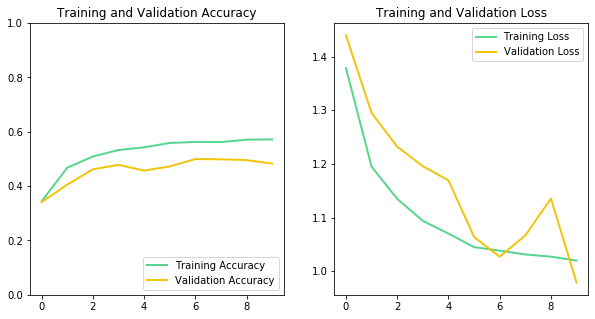

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

### Defreeze upper 10 Layers

In [154]:
for layer in base_model.layers:
    layer.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [155]:
for layer in base_model.layers:
    print(layer,layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x6db366690> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6db35cd90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6d7cac890> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x6db366350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6ce7bc850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6ce7c6d90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x648c83f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6ce7e49d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6ce7f7dd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6ce80afd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x6ce811ad0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x6dd4fa250> True
<tensorflow.pytho

In [156]:
# compile the model 
model.compile(optimizer='adam',            
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training and Evaluation

As above, we will only train 10 epochs due to computational limitations.

In [114]:
# Train the model
history2 = model.fit_generator(train_data_gen,
                      steps_per_epoch=total_train // batch_size,
                      validation_data=validation_data_gen,
                      validation_steps=total_val // batch_size,
                      epochs = epochs,
                      verbose = 1)

Epoch 1/10
77/77 [==============================] - 4666s 61s/step - loss: 0.9736 - accuracy: 0.5555 - val_loss: 30.2964 - val_accuracy: 0.2492
Epoch 2/10
77/77 [==============================] - 5655s 73s/step - loss: 0.5200 - accuracy: 0.7819 - val_loss: 9.3116 - val_accuracy: 0.4159
Epoch 3/10
77/77 [==============================] - 7496s 97s/step - loss: 0.3386 - accuracy: 0.8644 - val_loss: 1.6777 - val_accuracy: 0.6304
Epoch 4/10
77/77 [==============================] - 25114s 326s/step - loss: 0.2643 - accuracy: 0.8948 - val_loss: 3.0899 - val_accuracy: 0.6994
Epoch 5/10
77/77 [==============================] - 9517s 124s/step - loss: 0.2134 - accuracy: 0.9181 - val_loss: 3.6600 - val_accuracy: 0.5163
Epoch 6/10
77/77 [==============================] - 6976s 91s/step - loss: 0.1968 - accuracy: 0.9247 - val_loss: 2.6033 - val_accuracy: 0.6244
Epoch 7/10
77/77 [==============================] - 6911s 90s/step - loss: 0.1562 - accuracy: 0.9400 - val_loss: 2.8128 - val_accuracy: 0.

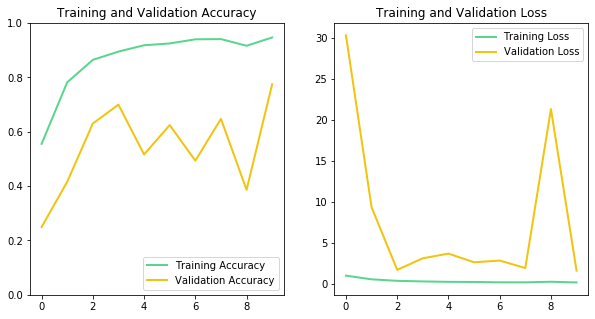

In [115]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

## Build a second model

In this second model we use fully connected layer as the additional layers instead of Global Average Pooling.

In [157]:
# adapted from https://www.kaggle.com/arpitjain007/vgg16-classification-v2
model2 = Sequential([base_model,
                    Flatten(),
                    BatchNormalization(),
                    Dense(32, activation='relu'),
                    Dropout(0.2),
                    BatchNormalization(),
                    Dense(16, activation='relu'),
                    Dropout(0.2),
                    BatchNormalization(),
                    Dense(8, activation='relu'),
                    Dropout(0.2),
                    BatchNormalization(),
                    Dense(4, activation='softmax')    
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7680)              30720     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                245792    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [158]:
for layer in base_model.layers:
    layer.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [159]:
model2.compile(optimizer='adam',            
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
history3 = model2.fit_generator(train_data_gen,
                      steps_per_epoch=total_train // batch_size,
                      validation_data=validation_data_gen,
                      validation_steps=total_val // batch_size,
                      epochs = epochs,
                      verbose = 1)

Epoch 1/10
77/77 [==============================] - 8347s 108s/step - loss: 0.7688 - accuracy: 0.7374 - val_loss: 2.7366 - val_accuracy: 0.3795
Epoch 2/10
77/77 [==============================] - 30253s 393s/step - loss: 0.5118 - accuracy: 0.8452 - val_loss: 19.4183 - val_accuracy: 0.6452
Epoch 3/10
77/77 [==============================] - 10125s 131s/step - loss: 0.4065 - accuracy: 0.8784 - val_loss: 2.5570 - val_accuracy: 0.5676
Epoch 4/10
77/77 [==============================] - 8141s 106s/step - loss: 0.3303 - accuracy: 0.9038 - val_loss: 5.8383 - val_accuracy: 0.6380
Epoch 5/10
77/77 [==============================] - 7638s 99s/step - loss: 0.2954 - accuracy: 0.9103 - val_loss: 1.1574 - val_accuracy: 0.6723
Epoch 6/10
77/77 [==============================] - 11956s 155s/step - loss: 0.2698 - accuracy: 0.9209 - val_loss: 0.8247 - val_accuracy: 0.7940
Epoch 7/10
77/77 [==============================] - 8866s 115s/step - loss: 0.2399 - accuracy: 0.9255 - val_loss: 12.9108 - val_accur

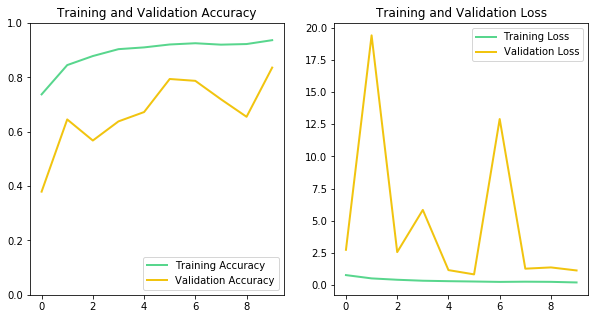

In [121]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

## Make Predictions

Use the second model to make some predictions.

In [122]:
sample_test_images, sample_test_labels = next(validation_data_gen)
predictions = model2.predict(sample_test_images)

In [124]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Prediction values of the first image: {}".format(predictions[i]))
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Prediction values of the first image: [0.01568638 0.02353356 0.9456496  0.0151304 ]
Predicted cell type of the first image: 2.
True label: 2
--------------------
Prediction values of the first image: [0.03787274 0.13134164 0.81637245 0.0144132 ]
Predicted cell type of the first image: 2.
True label: 2
--------------------
Prediction values of the first image: [7.4837834e-04 9.9676740e-01 6.4012920e-04 1.8441217e-03]
Predicted cell type of the first image: 1.
True label: 1
--------------------
Prediction values of the first image: [9.9995112e-01 6.2786426e-06 3.3183198e-06 3.9201612e-05]
Predicted cell type of the first image: 0.
True label: 0
--------------------
Prediction values of the first image: [1.5610096e-03 1.9510189e-04 1.1436867e-03 9.9710017e-01]
Predicted cell type of the first image: 3.
True label: 3


In [125]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = '#009933'
    else:
        color = '#cc0000'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('#cc0000')
    thisplot[true_label].set_color('#009933')

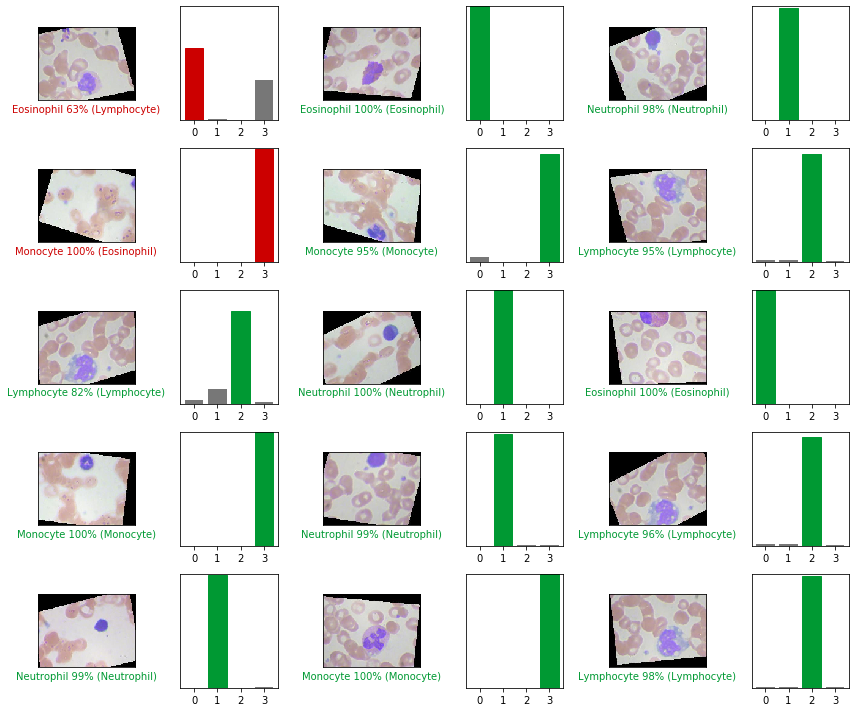

In [128]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# Color correct predictions in green and incorrect predictions in red.
class_names = ['Eosinophil', 'Neutrophil', 'Lymphocyte', 'Monocyte']
test_labels = sample_test_labels
test_images = sample_test_images
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Visualizations

Visualize some selected feature maps of the convolutional layers to sea how predictions evolve. 

The following code has been adapted from https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [136]:
# number of layers
ct=0
for layer in base_model.layers:
    ct+=1
print("Number of layers in the model {}".format(ct))

Number of layers in the model 19


In [143]:
# summarize feature map shape (=output shape) for each conv layer
print("Summary of convolutional layers' output (feature map) in the CNN:")
print("-"*30)
for i in range(len(base_model.layers)):
    layer = base_model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

Summary of convolutional layers' output (feature map) in the CNN:
------------------------------
1 block1_conv1 (None, 120, 160, 64)
2 block1_conv2 (None, 120, 160, 64)
4 block2_conv1 (None, 60, 80, 128)
5 block2_conv2 (None, 60, 80, 128)
7 block3_conv1 (None, 30, 40, 256)
8 block3_conv2 (None, 30, 40, 256)
9 block3_conv3 (None, 30, 40, 256)
11 block4_conv1 (None, 15, 20, 512)
12 block4_conv2 (None, 15, 20, 512)
13 block4_conv3 (None, 15, 20, 512)
15 block5_conv1 (None, 7, 10, 512)
16 block5_conv2 (None, 7, 10, 512)
17 block5_conv3 (None, 7, 10, 512)


In [200]:
# redefine model to output right after the first hidden layer
model_0 = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

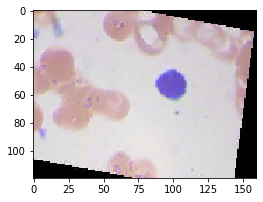

In [201]:
# test image
exp = 52
img = sample_test_images[exp]
# plot test image
plt.figure(figsize=(4, 4))
plt.imshow(img)
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model_0.predict(img)

In [202]:
print("Predicted Label: {} ({})".format(np.argmax(predictions[exp]), class_names[np.argmax(predictions[exp])]))
print("True Label: {} ({})".format(int(test_labels[exp]), class_names[int(test_labels[exp])]))

Predicted Label: 1 (Neutrophil)
True Label: 1 (Neutrophil)


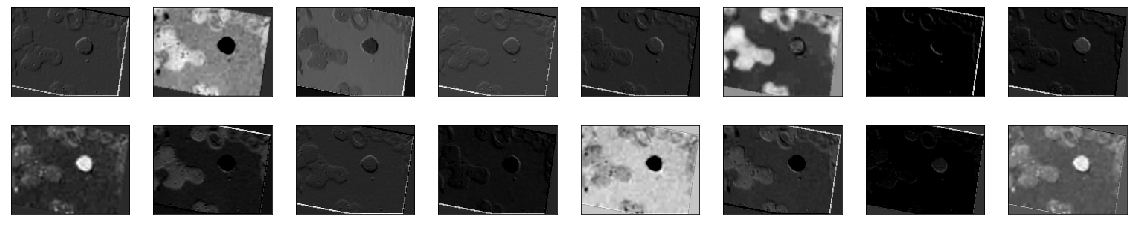

In [203]:
# plot all 16 maps (out of 64)
square = 8
ix = 1
plt.figure(figsize=(20, 4))
for _ in range(square):
    for _ in range(int(square/4)):
        # specify subplot and turn of axis
        ax = plt.subplot(square/4, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show();

In [204]:
# output after 4th-layer (third convlayer)
model_1 = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[4].output)
feature_maps = model_1.predict(img)

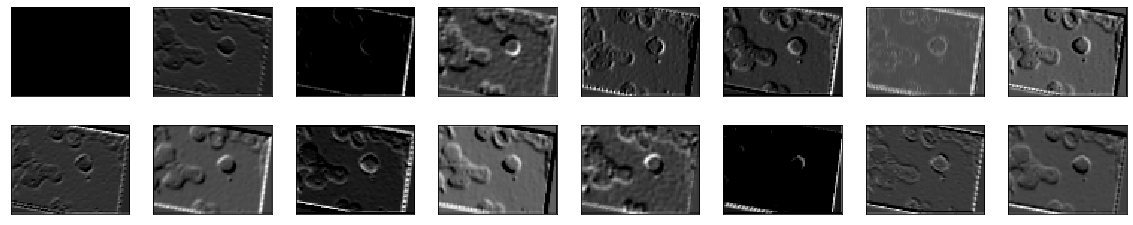

In [205]:
# plot 16 maps (out of 128)
square = 8
ix = 1
plt.figure(figsize=(20, 4))
for _ in range(square):
    for _ in range(int(square/4)):
        # specify subplot and turn of axis
        ax = plt.subplot(square/4, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show();

In [206]:
# output after 4th-layer (third convlayer)
model_3 = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[5].output)
feature_maps = model_3.predict(img)

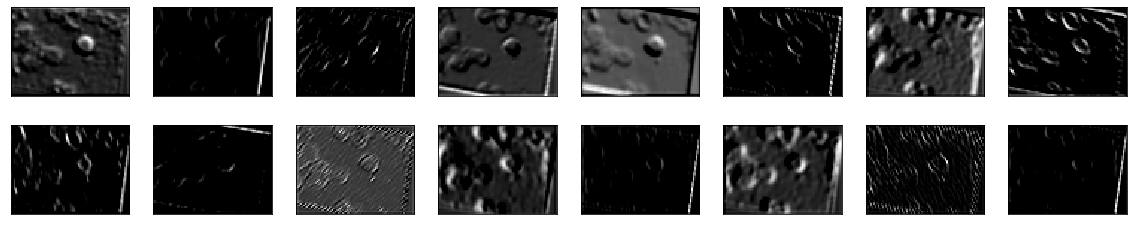

In [207]:
# plot 16 maps (out of 128)
square = 8
ix = 1
plt.figure(figsize=(20, 4))
for _ in range(square):
    for _ in range(int(square/4)):
        # specify subplot and turn of axis
        ax = plt.subplot(square/4, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show();

In [208]:
# output after 11th-layer (third convlayer)
model_4 = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[11].output)
feature_maps = model_4.predict(img)

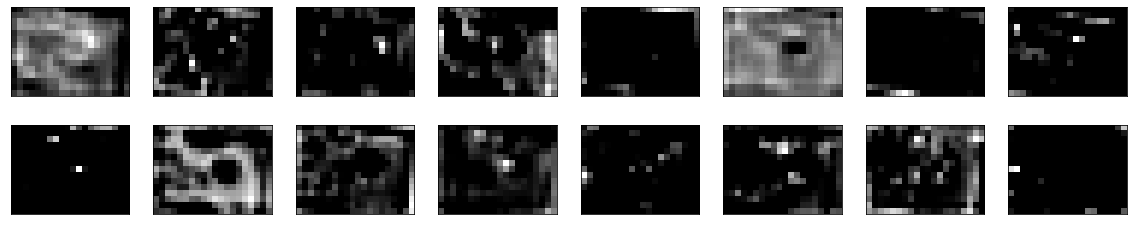

In [209]:
# plot 16 maps (out of 512)
square = 8
ix = 1
plt.figure(figsize=(20, 4))
for _ in range(square):
    for _ in range(int(square/4)):
        # specify subplot and turn of axis
        ax = plt.subplot(square/4, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show();

In [210]:
# output after 4th-layer (third convlayer)
model_5 = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[15].output)
feature_maps = model_5.predict(img)

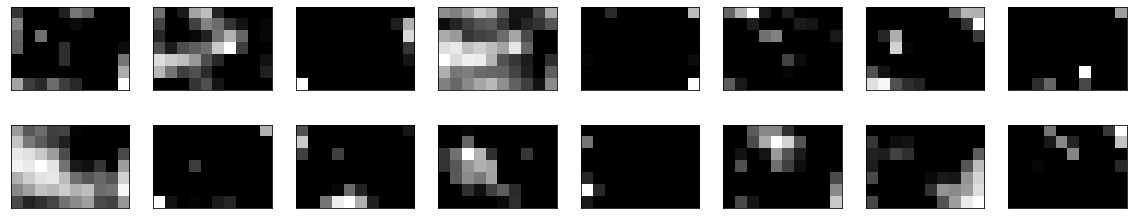

In [211]:
# plot 16 maps (out of 512)
square = 8
ix = 1
plt.figure(figsize=(20, 4))
for _ in range(square):
    for _ in range(int(square/4)):
        # specify subplot and turn of axis
        ax = plt.subplot(square/4, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show();

## Conclusions

It is difficult to draw sophisticated conclusions from this analysis, since the training has been very short. What we see is that only adding an output layer without defreezing any layer does not lead to high accuracy. Validation accuracy  stays below 0.5. Defreezing the upper layers improves accuracy, but more training would be neccessary to see to see to which value it converges.

Looking at the feature maps shows how the lower layers resolve more detailed information, while the upper once more general information.

## Future work

Train all models for more epochs to see to which accuracy they converge. This has to be done with different resources.